### Ali Darabi - 810100264
### Hesam Ramezanian - 810100248

# Data Science - Assignment 7

In [91]:
'''

!pip install -U accelerate
!pip install -U transformers

'''

'\n\n!pip install -U accelerate\n!pip install -U transformers\n\n'

In [92]:
'''

from google.colab import drive
drive.mount('/content/drive')

'''

"\n\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n"

## <span style="color: orange;">Imports :</span>

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import train_test_split

## <span style="color: orange;"> Load model :</span>

In [94]:
MODEL_ARGS = {
    'Name': 'microsoft/Phi-3-mini-128k-instruct',
    'DType': torch.bfloat16
}
device = "cuda" if torch.cuda.is_available() else "cpu"

In [95]:
def load_model(model_args):


    model = AutoModelForCausalLM.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
        torch_dtype=model_args['DType'],
        low_cpu_mem_usage=True,
        device_map={"": device},
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
    )

    return model, tokenizer

## <span style="color: orange;"> 1. EDA :</span>

In [96]:
filePath = 'train_imdb.jsonl'
trainData = pd.read_json(filePath, lines=True)
trainData.head()

,text,label,embedding
0,fairly good romantic comedy in which i don't t...,1,"[-0.0167805497, -0.0395836979, 0.1233159453000..."
1,"""dressed to kill"", is one of the best thriller...",1,"[-0.12526972590000002, 0.10147688540000001, 0...."
2,i'm glad that users (as of this date) who like...,1,"[0.1312361956, 0.0294876788, 0.2328549027, -0...."
3,needed an excuse to get out of the house while...,0,"[0.1387384981, 0.0460377187, 0.3447172046, -0...."
4,john candy's performance in once upon a crime ...,1,"[0.1606466323, -0.1768193543, 0.35633808370000..."


In [97]:
filePath = 'test_imdb.jsonl'
testData = pd.read_json(filePath, lines=True)
testData.head()

,text,label,embedding
0,the 60s (1999) d: mark piznarski. josh hamilto...,0,"[-0.2179879397, -0.1741176099, 0.0884851664000..."
1,hello. this movie is.......well.......okay. ju...,1,"[-0.07834710930000001, -0.279764235, 0.6189775..."
2,eyeliner was worn nearly 6000 years ago in egy...,1,"[0.03139963, -0.1652034372, 0.1265712678, -0.0..."
3,"this has to be, by far, the absolute worst mov...",0,"[-0.0552324504, -0.1593759954, 0.0467776954, -..."
4,"i like silent films, but this was a little too...",0,"[0.0934860557, 0.026243483600000003, 0.0843501..."


In [98]:
filePath = 'aug_imdb_unlabeled.jsonl'
unlabeledData = pd.read_json(filePath, lines=True)
unlabeledData['label'] = -1
col = unlabeledData.pop('label')
unlabeledData.insert(1, 'label', col)
unlabeledData.head()

,text,label,embedding
0,there is no relation at all between fortier an...,-1,"[-0.09757755700000001, -0.1536363065, 0.311417..."
1,in the process of trying to establish the audi...,-1,"[-0.00033669360000000004, 0.08777780830000001,..."
2,i give this movie 7 out of 10 because the vill...,-1,"[-0.275570631, -0.32913637160000003, 0.0793179..."
3,this is the best sci-fi that i have seen in my...,-1,"[0.1461943835, -0.2785910368, 0.4456491172, -0..."
4,what an appalling piece of rubbish!!! who are ...,-1,"[0.1696606129, 0.354041934, 0.4451519549000000..."


In [99]:
allData = pd.concat([trainData, unlabeledData, testData], ignore_index=True)
print("\nShape of the result DataFrame:", allData.shape)


Shape of the result DataFrame: (1314, 3)


In [100]:
allData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1314 non-null   object
 1   label      1314 non-null   int64 
 2   embedding  1314 non-null   object
dtypes: int64(1), object(2)
memory usage: 30.9+ KB


In [101]:
len(allData['embedding'][0])

768

In [102]:
def convertToArray(embedding):
    if isinstance(embedding, str):
        embedding = eval(embedding)
    return np.array(embedding)

allData['embedding'] = allData['embedding'].apply(convertToArray)

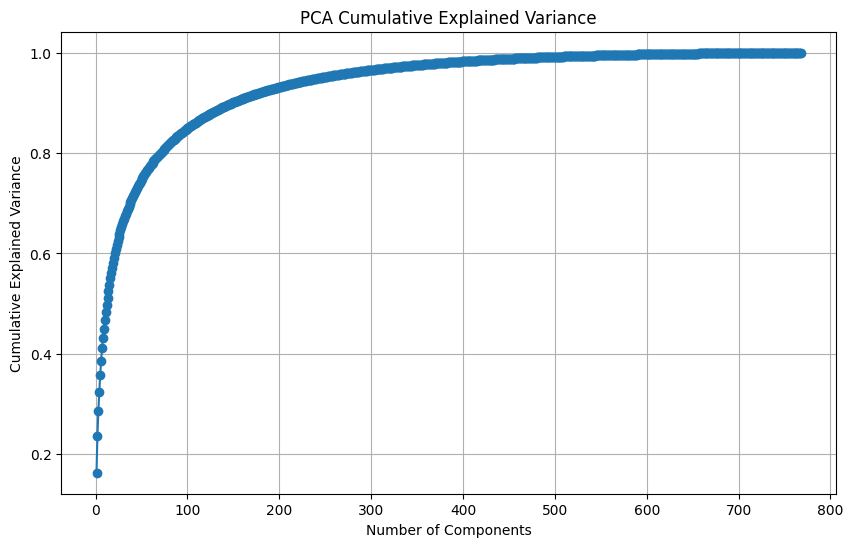

In [103]:
embeddings = np.stack(allData['embedding'].values)
pca = PCA()
pca.fit(embeddings)
cumulativeExplainedVariance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulativeExplainedVariance) + 1), cumulativeExplainedVariance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [104]:
allData['text_length'] = allData['text'].apply(len)
allData['text_length']

0       382
1       702
2       684
3       653
4       238
       ... 
1309    286
1310    668
1311    660
1312    680
1313    611
Name: text_length, Length: 1314, dtype: int64

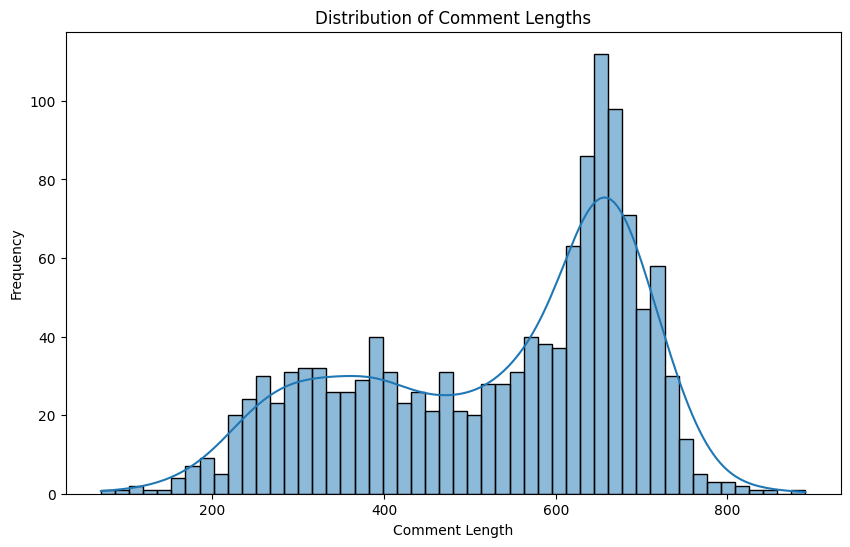

In [105]:
def plotTextLengthDistribution(df, column='text_length', title='Distribution of Comment Lengths', xlabel='Comment Length', ylabel='Frequency', figsize=(10, 6), bins=50):
    plt.figure(figsize=figsize)
    sns.histplot(df[column], bins=bins, kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

plotTextLengthDistribution(allData)

In [106]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alida\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alida\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alida\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [107]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_text(text):
    tokens = word_tokenize(text)
    return ' '.join([stemmer.stem(token) for token in tokens if token.isalpha()])

def lemmatize_text(text):
    tokens = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(token) for token in tokens if token.isalpha()])

In [108]:
def preprocessText(df, text_column='text', stem_column='stemmed_text', lemma_column='lemmatized_text'):
    processedDf = df.copy()
    processedDf[stem_column] = processedDf[text_column].apply(stem_text)
    processedDf[lemma_column] = processedDf[text_column].apply(lemmatize_text)
    return processedDf

allData = preprocessText(allData)
allData[['text', 'stemmed_text', 'lemmatized_text']].head()

,text,stemmed_text,lemmatized_text
0,fairly good romantic comedy in which i don't t...,fairli good romant comedi in which i do think ...,fairly good romantic comedy in which i do thin...
1,"""dressed to kill"", is one of the best thriller...",dress to kill is one of the best thriller ever...,dressed to kill is one of the best thriller ev...
2,i'm glad that users (as of this date) who like...,i glad that user as of thi date who like thi m...,i glad that user a of this date who liked this...
3,needed an excuse to get out of the house while...,need an excus to get out of the hous while pai...,needed an excuse to get out of the house while...
4,john candy's performance in once upon a crime ...,john candi perform in onc upon a crime is poss...,john candy performance in once upon a crime is...


In [109]:
allData['text'] = allData['text'].str.replace('<br />', '')

In [110]:
def generateWordCloud(data, method, stop_words):
    if method == 'lemmatized':
        allComments = ' '.join(data['lemmatized_text'])
        title = 'Word Cloud of Lemmatized Texts'
    elif method == 'stemmed':
        allComments = ' '.join(data['stemmed_text'])
        title = 'Word Cloud of Stemmed Texts'
    else:
        print("Invalid method.")
        return

    wordcloud = WordCloud(stopwords=stop_words, background_color='white', max_words=100).generate(allComments)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

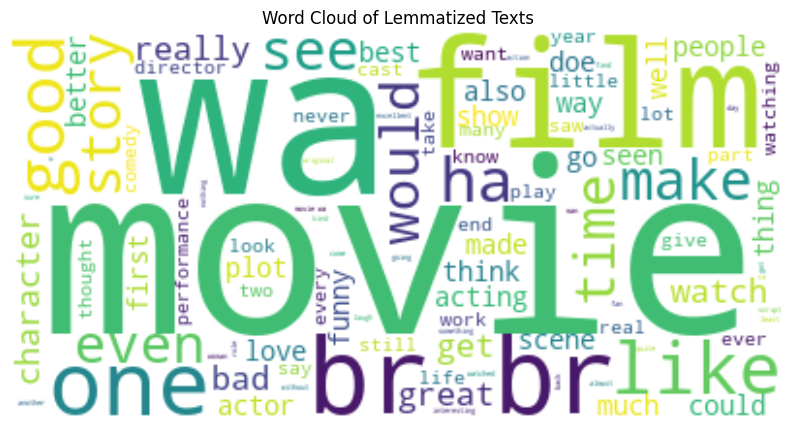

In [111]:
generateWordCloud(allData, 'lemmatized', stop_words)

In [112]:
def getMostCommonWords(df, text_column='text', n=20, language='english', ignore_first=True):
    words = [word.lower() for review in df[text_column] for word in review.split() if word.lower() not in stop_words]
    common_words = Counter(words).most_common(n)
    common_words_df = pd.DataFrame(common_words, columns=['Word', 'Count'])
    return common_words_df

mostCommonWords = getMostCommonWords(allData)
print("Most common words:")
print(mostCommonWords)

Most common words:
      Word  Count
0    movie   1056
1     film    654
2      one    586
3     like    462
4     good    392
5     even    291
6      see    289
7   really    269
8    would    254
9    story    235
10   great    234
11     bad    216
12  movie.    203
13   watch    203
14       -    202
15   think    199
16     get    195
17  people    192
18    make    188
19    made    187


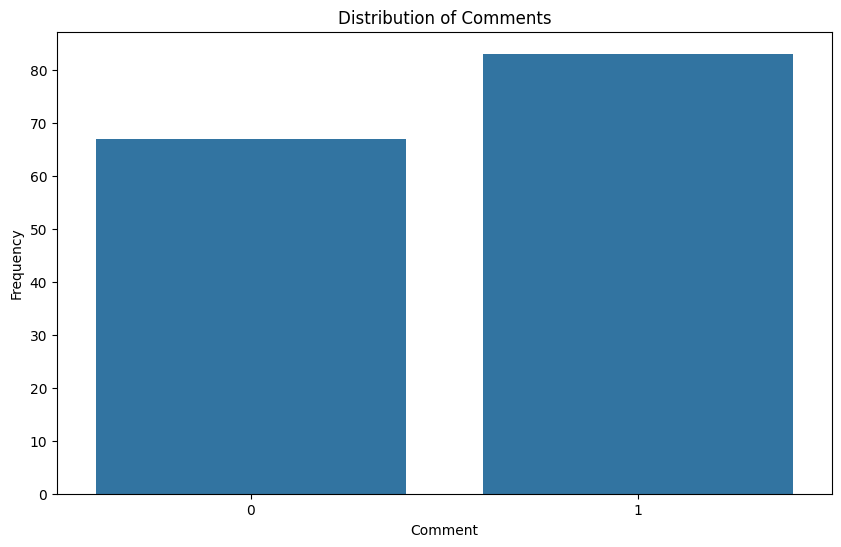

In [113]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=trainData)
plt.title('Distribution of Comments')
plt.xlabel('Comment')
plt.ylabel('Frequency')
plt.show()

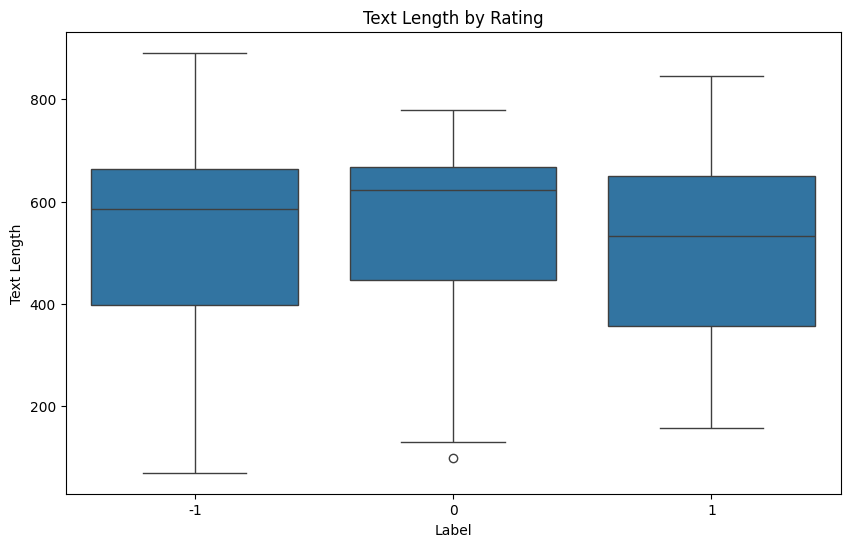

In [114]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='text_length', data=allData)
plt.title('Text Length by Rating')
plt.xlabel('Label')
plt.ylabel('Text Length')
plt.show()

In [115]:
def generateNgrams(text, n):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha() and token.lower() not in stop_words]
    n_grams = ngrams(tokens, n)
    return [' '.join(grams) for grams in n_grams]

allData['bigrams'] = allData['text'].apply(lambda x: generateNgrams(x, 2))
all_bigrams = [bigram for text in allData['bigrams'] for bigram in text]
common_bigrams = Counter(all_bigrams).most_common(21)

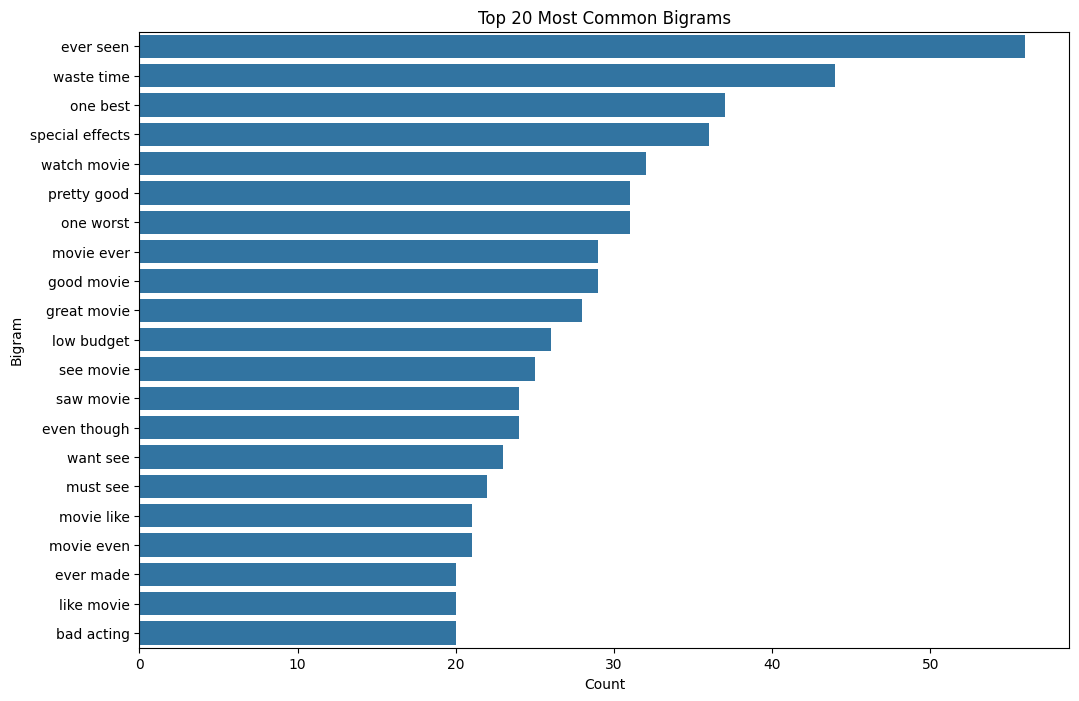

In [116]:
bigramsDf = pd.DataFrame(common_bigrams, columns=['Bigram', 'Count'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Bigram', data=bigramsDf)
plt.title('Top 20 Most Common Bigrams')
plt.show()

EDA on text data involves:

* **Word Frequency Analysis**: Calculating and visualizing the frequency distribution of words to identify common words, topics, and themes present in the text data.

* **N-gram Analysis**: Analyzing the frequency of n-grams (sequences of n words) to uncover common phrases, collocations, and multi-word expressions.

* **Keyword Extraction**: Using techniques like TF-IDF (Term Frequency-Inverse Document Frequency) to identify the most important or representative keywords that capture the main topics or concepts covered in the text.

* **Topic Modeling**: Applying techniques like Latent Dirichlet Allocation (LDA) or Non-negative Matrix Factorization (NMF) to automatically discover the underlying topics or themes present in the text data and analyze their prevalence and importance.

Additionally, text preprocessing steps are often performed before EDA, including:

* **Tokenization**: Splitting text into individual words or tokens.
* **Stopwords Removal**: Removing common words that do not add significant meaning.
* **Stemming and Lemmatization**: Reducing words to their base or root form.

## <span style="color: orange;"> 2. Feature Engineering :</span>

In [117]:
def findElbowPoint(cumulativeExplainedVariance):
    diff = np.diff(cumulativeExplainedVariance)
    diffRatio = diff[1:] / diff[:-1]
    elbowPoint = np.argmax(diffRatio) + 1
    return elbowPoint

elbowPoint = findElbowPoint(cumulativeExplainedVariance)
print(f'Elbow point: {elbowPoint}')

numComponents = elbowPoint

pca = PCA(n_components=numComponents)
embeddingsPca = pca.fit_transform(embeddings)

allData['embeddingPca'] = list(embeddingsPca)
allData.drop('embedding', axis=1, inplace=True)

print(f'Original number of dimensions: {embeddings.shape[1]}')
print(f'Reduced number of dimensions: {embeddingsPca.shape[1]}')

Elbow point: 302
Original number of dimensions: 768
Reduced number of dimensions: 302


<span style="color: pink;"> We reduced the size of embedding vectors using PCA and the elbow method to manage computational costs, as using all of them would lead to excessively high compute costs. </span>

In [118]:
allData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             1314 non-null   object
 1   label            1314 non-null   int64 
 2   text_length      1314 non-null   int64 
 3   stemmed_text     1314 non-null   object
 4   lemmatized_text  1314 non-null   object
 5   bigrams          1314 non-null   object
 6   embeddingPca     1314 non-null   object
dtypes: int64(2), object(5)
memory usage: 72.0+ KB


<span style="color: pink;"> We create and add `text_length`, `stemmed_text`, `lemmatized_text`, and `bigrams` in the EDA part. </span>

In [119]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return sia.polarity_scores(text)

allData['sentiment'] = allData['text'].apply(get_sentiment)
allData['compound'] = allData['sentiment'].apply(lambda x: x['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alida\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [120]:
allData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text             1314 non-null   object 
 1   label            1314 non-null   int64  
 2   text_length      1314 non-null   int64  
 3   stemmed_text     1314 non-null   object 
 4   lemmatized_text  1314 non-null   object 
 5   bigrams          1314 non-null   object 
 6   embeddingPca     1314 non-null   object 
 7   sentiment        1314 non-null   object 
 8   compound         1314 non-null   float64
dtypes: float64(1), int64(2), object(6)
memory usage: 92.5+ KB


In [121]:
trainData = allData.iloc[:150]
unlabeledData = allData.iloc[150:1164]
testData = allData.iloc[1164:]
unlabeledData = unlabeledData.reset_index()
testData = testData.reset_index()
testData = testData.drop('index', axis=1)
unlabeledData = unlabeledData.drop('index', axis=1)

## <span style="color: orange;"> 3. Semi-Supervised :</span>

Label propagation techniques are used in machine learning to assign labels to unlabeled data based on the labels of neighboring data points. One traditional method for label propagation is using KNN (K-Nearest Neighbors). Here's a simple breakdown of how it works:

1. **K-Nearest Neighbors (KNN)**: In this method, for each unlabeled data point, the algorithm looks at its K nearest labeled neighbors.
2. **Majority Voting**: It assigns the label to the unlabeled data point based on the most common label among its K nearest neighbors.
3. **Distance Metric**: The "nearest" neighbors are determined based on a distance metric, often Euclidean distance, but other metrics can be used depending on the data characteristics.

So, in short, using KNN for label propagation involves finding the nearest labeled data points to the unlabeled ones and assigning labels based on the most common labels among those neighbors.

### <span style="color: orange;">Using Traditional Methods (Label Propagation)</span>

In [122]:
XLabeled = np.stack(trainData['embeddingPca'].values)
yLabeled = trainData['label'].values
XUnlabeled = np.stack(unlabeledData['embeddingPca'].values)

In [123]:
classifier = RandomForestClassifier(random_state=64)
classifier.fit(XLabeled, yLabeled)
probs = classifier.predict_proba(XUnlabeled)
uncertainties = 1 - np.max(probs, axis=1)
numUncertain = int(0.25 * len(uncertainties))
uncertainIndices = uncertainties.argsort()[-numUncertain:]
mask = np.ones(len(XUnlabeled), dtype=bool)
mask[uncertainIndices] = False
XCertainUnlabeled = XUnlabeled[mask]
XCombined = np.vstack((XLabeled, XCertainUnlabeled))
yCombined = np.concatenate([yLabeled, -1 * np.ones(XCertainUnlabeled.shape[0])])

<font color='cyan'>We utilized RandomForest as our classifier. Initially, we selected 25% of the unlabeled data, identified by having less information than others using a trained model on the train data, to remove, as using all of it could lead to performance issues due to high variance. Subsequently, we combined labeled and unlabeled data to train our model using the active learning method.</font>

In [124]:
model = SelfTrainingClassifier(classifier, criterion='k_best', k_best=10)
model.fit(XCombined, yCombined)
_, XTest, _, yTest = train_test_split(XCombined[yCombined != -1], yCombined[yCombined != -1], test_size=0.2, random_state=19)
yPred = model.predict(XTest)
print(classification_report(yTest, yPred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        13
         1.0       1.00      1.00      1.00        17

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [125]:
yPred = model.predict(np.stack(testData['embeddingPca'].values))
print(classification_report(testData['label'].values, yPred))

              precision    recall  f1-score   support

           0       0.60      0.04      0.07        78
           1       0.48      0.97      0.65        72

    accuracy                           0.49       150
   macro avg       0.54      0.51      0.36       150
weighted avg       0.54      0.49      0.35       150



<font color='cyan'>Our label propagation method's accuracy suffers because it's influenced by bias from our training data.</font>

<font color='cyan'>We also explored other classification methods such as Decision Trees and KNN, but none performed better than RandomForest.</font>

### <span style="color: orange;">Using LLMs</span>

#### 1. **Zero-Shot Classification**
- **How It Works:** Uses pre-trained knowledge to classify text without task-specific training.
- **When to Use:** 
  - No labeled data available.
  - Quick prototyping and broad generalization needed.

#### 2. **Few-Shot Classification**
- **How It Works:** Provides a few examples with the prompt to guide the model.
- **When to Use:**
  - Limited labeled data.
  - Task requires specific examples for better understanding.

#### 3. **Fine-Tuning**
- **How It Works:** Trains the LLM on a specific labeled dataset for the task.
- **When to Use:**
  - High accuracy needed.
  - Sufficient labeled data is available.
  - Domain-specific tasks.

#### 4. **Transfer Learning**
- **How It Works:** Adapts a pre-trained model with task-specific data.
- **When to Use:**
  - Some labeled data available.
  - Task relates to but differs from the pre-trained domain.

#### 5. **Prompt Engineering**
- **How It Works:** Crafts specific prompts to guide the model in zero-shot or few-shot scenarios.
- **When to Use:**
  - Need quick adaptation to different tasks.
  - Complex tasks requiring clear guidance.

In [126]:
#model, tokenizer = load_model(MODEL_ARGS)

In [127]:
def generateText(model, tokenizer, prompt, max_new_tokens = 100, do_sample=True, temperature=0.5):
    inputIds = tokenizer.encode(prompt, return_tensors='pt').to(device)
    if do_sample:
        outputIds = model.generate(inputIds, max_new_tokens=max_new_tokens, do_sample=True, temperature=temperature)
    else:
        outputIds = model.generate(inputIds, max_new_tokens=max_new_tokens, do_sample=do_sample)

    outputText = tokenizer.decode(outputIds[0], skip_special_tokens=True)
    return outputText[len(prompt) + 1:]

In [128]:
'''

prompt = """Instruction: Tell me a funny story about a cute cat
Answer:"""

generateText(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=200,
    temperature=1.2,
)

'''

'\n\nprompt = """Instruction: Tell me a funny story about a cute cat\nAnswer:"""\n\ngenerateText(\n    model=model,\n    tokenizer=tokenizer,\n    prompt=prompt,\n    max_new_tokens=200,\n    temperature=1.2,\n)\n\n'

In [129]:
templatePrompt = """Instruction: Classify the following comments as "good" (Label = 1) or "bad" (Label = 0) based on their content.
comment :"Fairly good romantic comedy. Meg looks cute. Lively romp. Unrealistic but fun. Nice film. Meg is a babe." , Label: 1
comment :"Thought it would be typical but Diane joined boxing because she wanted to. Gave it 8/10. Michelle Rodriguez always good.", Label: 1
comment :"Complained to ABC about Six Degrees cancellation. Fantastic show, gripping concept. Astounded it's over after one series.", Label: 1
comment :"Really enjoyed the movie. Fresh script, outstanding acting. Brought tears and left a great feeling.", Label: 1
comment :"Filmmaker captured Andy Goldsworthy's art beautifully. 'Rivers and Tides' is a visual concert of time and presence. See this movie!", Label: 1
comment :"Movie gets a 1 because zero isn't an option. Gross and creepy. Hated it, not scary but mentally scarring. Don't rent/buy.", Label: 0
comment :"Close to worst film by Peter Greenaway. Miserable like 'The Cook...'. Repugnant material and presentation.", Label: 0
comment :"Virtually impossible to follow. Poor sound and picture quality. Vile story with sick content. Felt ashamed and dirty.", Label: 0
comment :"Straightforward, boring comedy. Some liked it but I prefer intelligent humor. Known Swedish actors were decent.", Label: 0
comment :"Don't waste time or money. Half decent cast but no entertainment. Leaves you wondering how it was made.", Label: 0
Now, classify the following comment like example before I give you comment and only give me the label (1 or 0) and do not explain anything:
comment :"{replace_me}", Label:
Answer:"""

def generatePrompt(comment):
    return templatePrompt.replace("{replace_me}", comment)

def findLabel(text):
    if '0' in text:
        return 0
    if '1' in text:
        return 1
    return -1

In [130]:
'''

def save_results_to_csv(results, filename):
    df = pd.DataFrame(results, columns=['index', 'label'])
    if pd.io.common.file_exists(filename):
        df.to_csv(filename, mode='a', header=False, index=False)
    else:
        df.to_csv(filename, index=False)

resultsFilename = 'results.csv'
batchSize = 50
totalSize = len(unlabeledData['text'])

for startIdx in range(0, totalSize, batchSize):
    labels = []
    endIdx = min(startIdx + batchSize, totalSize)
    for i in range(startIdx, endIdx):
        newLabel = generateText(
            model=model,
            tokenizer=tokenizer,
            prompt=generatePrompt(unlabeledData['text'][i]),
            max_new_tokens=200,
            temperature=1.2,
        )
        labels.append(newLabel)

    results = []
    for i in range(len(labels)):
        label = findLabel(labels[i])
        results.append((startIdx + i, label))

    save_results_to_csv(results, resultsFilename)

'''

"\n\ndef save_results_to_csv(results, filename):\n    df = pd.DataFrame(results, columns=['index', 'label'])\n    if pd.io.common.file_exists(filename):\n        df.to_csv(filename, mode='a', header=False, index=False)\n    else:\n        df.to_csv(filename, index=False)\n\nresultsFilename = 'results.csv'\nbatchSize = 50\ntotalSize = len(unlabeledData['text'])\n\nfor startIdx in range(0, totalSize, batchSize):\n    labels = []\n    endIdx = min(startIdx + batchSize, totalSize)\n    for i in range(startIdx, endIdx):\n        newLabel = generateText(\n            model=model,\n            tokenizer=tokenizer,\n            prompt=generatePrompt(unlabeledData['text'][i]),\n            max_new_tokens=200,\n            temperature=1.2,\n        )\n        labels.append(newLabel)\n\n    results = []\n    for i in range(len(labels)):\n        label = findLabel(labels[i])\n        results.append((startIdx + i, label))\n\n    save_results_to_csv(results, resultsFilename)\n\n"

<font color='cyan'>For labeling unlabeled data with LLM, we employed prompt engineering (We used key points of comments instead of the actual comments themselves.). We created a template prompt and appended each comment to it before presenting it to the LLM. We processed labels in batches of 50 rows, saving them in a CSV file to ensure data preservation.</font>

<font color='cyan'>We experimented with various methods, including without prompt engineering and excessive prompt engineering. However, these approaches resulted in either underfitting or overfitting, indicating a lack of balance in the model's performance. 
</font>

In [131]:
labels = pd.read_csv('results.csv')
labels.head()

,index,label
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0


In [132]:
unlabeledData['label'] = labels['label']
unlabeledData = unlabeledData[mask]
unlabeledData['label']

0       0
1       0
2       0
3       1
4       0
       ..
1009    0
1010    1
1011    1
1012    0
1013    0
Name: label, Length: 761, dtype: int64

In [133]:
XLabeled = np.stack(trainData['embeddingPca'].values)
yLabeled = trainData['label'].values
XUnlabeled = np.stack(unlabeledData['embeddingPca'].values)
yUnlabeled  = unlabeledData['label'].values
XCombined = np.vstack((XLabeled, XUnlabeled))
yCombined = np.concatenate([yLabeled, yUnlabeled])

In [134]:
model = RandomForestClassifier(random_state=64)
model.fit(XCombined, yCombined)

RandomForestClassifier(random_state=64)

In [135]:
yPred = model.predict(np.stack(testData['embeddingPca'].values))
print(classification_report(testData['label'].values, yPred))

              precision    recall  f1-score   support

           0       0.59      0.96      0.73        78
           1       0.86      0.26      0.40        72

    accuracy                           0.63       150
   macro avg       0.72      0.61      0.57       150
weighted avg       0.72      0.63      0.57       150



<font color='cyan'>As you can see, when using the LLM to assign labels, our accuracy increased by approximately 15% compared to the label propagation method.</font>

<font color='cyan'>We assessed the accuracy of the LLM using our labeled data. The accuracy ranged between 75% to 80%. We believe that this variation might be due to comments containing both positive and negative views, leading the LLM to occasionally choose the wrong label.</font>

## <span style="color: orange;">Questions:</span>

### <span style="color: pink;">1. Research semi-supervised problems and explain how to select a proportion of data for manual labeling. Does the choice of data matter?</span>

**Semi-supervised learning (SSL)** combines a small amount of labeled data with a large amount of unlabeled data to improve model accuracy. Selecting which data to label is crucial for effective learning.

#### Why Data Choice Matters

1. **Representative Samples**: Labeled data should reflect the overall dataset to teach the model correctly.
2. **Class Balance**: Avoids bias by ensuring all classes are fairly represented.
3. **Key Regions**: Focus on data near decision boundaries or uncertain areas to improve model understanding.
4. **Diversity**: A variety of samples helps the model generalize better.

#### Strategies for Selecting Data

1. **Random Sampling**
   - **What**: Randomly picks data points.
   - **Pros**: Easy to implement.
   - **Cons**: May not cover all important areas.

2. **Stratified Sampling**
   - **What**: Selects samples with a class distribution matching the entire dataset.
   - **Pros**: Ensures class balance.
   - **Cons**: Needs knowledge of class distribution.

3. **Uncertainty Sampling**
   - **What**: Chooses samples where the model is unsure.
   - **Pros**: Focuses on informative samples.
   - **Cons**: Requires initial model training.

4. **Diversity Sampling**
   - **What**: Selects varied samples across the data space.
   - **Pros**: Covers diverse scenarios.
   - **Cons**: May miss difficult cases.

5. **Active Learning**
   - **What**: Model iteratively selects samples to label.
   - **Pros**: Continually improves performance.
   - **Cons**: Needs multiple training rounds.

#### Proportion of Data for Labeling

1. **Small Proportion (5-10%)**
   - **When**: Large dataset, limited budget.
   - **Approach**: Start with random or stratified sampling, refine with uncertainty sampling.

2. **Medium Proportion (10-30%)**
   - **When**: Moderate dataset size and budget.
   - **Approach**: Use a mix of uncertainty and diversity sampling.

3. **Large Proportion (30-50%)**
   - **When**: Small datasets or critical applications.
   - **Approach**: Use comprehensive sampling, consider active learning.

#### <span style="color: pink;">2. For label propagation, how many data points did you label using your manually labeled data? Explain the trade-off between quality and quantity of your labeled data.</span>

We had 150 rows of training data with labels and 1014 rows of unlabeled data. To propagate labels, we chose to label 75% of the unlabeled data.
The trade-off between the quality and quantity of labeled data is a fundamental consideration in machine learning. 

- **Quality of labeled data:** The quality of labeled data refers to how accurately and reliably the labels represent the true classes or categories of the data points. Higher quality labeled data typically leads to better performance in machine learning models because the labels are more trustworthy and informative.

- **Quantity of labeled data:** The quantity of labeled data refers to the number of data points that have been labeled. Having more labeled data can provide the model with a broader range of examples to learn from, potentially capturing more diverse patterns and improving generalization. However, labeling data can be time-consuming and expensive, so there's often a practical limit to how much labeled data is available.

We chose to label 75% of the unlabeled data to strike a balance between quality and quantity. By labeling a significant portion of the unlabeled data, we increase the quantity of labeled data available for training, which can help improve the model's performance. However, labeling too much data might introduce noise or inaccuracies, reducing the overall quality of the labeled data. 

#### <span style="color: pink;">3. Research the limitations of label propagation methods. Can these limitations be overcome using a large language model (LLM)? If yes, explain how and why using LLMs is more effective for these tasks.</span>

Label propagation methods have limitations such as sensitivity to initial labeled data, difficulty handling noise, and challenges with scaling to large datasets. Large language models (LLMs) can overcome some of these limitations.

LLMs like GPT can help in label propagation by leveraging their understanding of natural language. They can analyze and interpret textual data to extract meaningful information, which can then be used to improve the labeling process. LLMs can also handle noisy data more effectively by learning from diverse examples and patterns in the text.

Moreover, LLMs can scale well to large datasets, allowing them to process vast amounts of unlabeled data efficiently. Their ability to learn from unlabeled data and transfer knowledge across tasks makes them effective for tasks like label propagation.

#### <span style="color: pink;">4. Research the history of language modeling, their evolution, and explain how they work. Discuss the advantages and limitations of language models, especially large language models (LLMs), in various tasks.</span>

Language modeling has a rich history that spans several decades, evolving from simple statistical models to sophisticated neural network-based approaches. These models aim to predict the next word in a sequence of words based on the context provided by the preceding words.

Advantages of language models, especially large ones:

1. **Improved Understanding:** LLMs, like GPT, capture complex linguistic patterns and semantic relationships, enabling them to understand and generate human-like text.

2. **Generalization:** They can generalize across different tasks and domains by learning from vast amounts of data, making them versatile for various natural language processing tasks.

3. **Efficiency:** LLMs can process and generate text quickly, speeding up tasks like language translation, text summarization, and content generation.

Limitations:

1. **Data Dependency:** LLMs require large amounts of data to train effectively, limiting their accessibility and applicability in resource-constrained environments.

2. **Bias:** They may inherit biases present in the training data, leading to biased outputs and reinforcing societal prejudices.

3. **Computation Cost:** Training and fine-tuning LLMs can be computationally expensive, requiring specialized hardware and significant time and resources.

#### <span style="color: pink;">5. For each method (LLM/Label-Propagation), explain its advantages and disadvantages.</span>

**Large Language Models (LLMs):**

Advantages:
1. **Natural Language Understanding:** LLMs like GPT excel at understanding and generating human-like text, making them effective for a wide range of natural language processing tasks.
2. **Versatility:** They can generalize across tasks and domains, leveraging pre-trained knowledge to perform various language-related tasks.
3. **Efficiency:** LLMs can process and generate text quickly, speeding up tasks like language translation, text summarization, and content generation.

Disadvantages:
1. **Data Dependency:** LLMs require large amounts of data to train effectively, limiting their accessibility and applicability in resource-constrained environments.
2. **Bias:** They may inherit biases present in the training data, leading to biased outputs and reinforcing societal prejudices.
3. **Computation Cost:** Training and fine-tuning LLMs can be computationally expensive, requiring specialized hardware and significant time and resources.

**Label Propagation:**

Advantages:
1. **Simplicity:** Label propagation is conceptually simple and easy to implement, making it accessible for basic semi-supervised learning tasks.
2. **Efficiency:** It can efficiently propagate labels across a large dataset, leveraging the similarity between data points to infer labels for unlabeled instances.
3. **Scalability:** Label propagation methods can scale to large datasets, making them suitable for applications with extensive unlabeled data.

Disadvantages:
1. **Sensitivity to Initial Labels:** Performance can be sensitive to the quality and quantity of initial labeled data, affecting the accuracy of propagated labels.
2. **Noise Sensitivity:** Label propagation methods may struggle with noisy or ambiguous data, leading to inaccuracies in label assignment.
3. **Limited Modeling Capability:** They may not capture complex linguistic patterns or semantic relationships present in natural language data, limiting their effectiveness for certain tasks compared to more advanced language models.

#### <span style="color: pink;">6. Certainly, you have worked with large language models (LLMs) since they were made public, and you might even be using one right now to help you with your assignment! How has your experience been while interacting with one of them? How do other LLMs differ from each other? Name some of these LLMs that you have worked with and share your opinion about them.</span>

Working with large language models has been quite fascinating! They've been incredibly helpful in assisting with various tasks, providing quick and relevant information, generating text, and even helping with creative writing. Each LLM has its own strengths and weaknesses, and they differ in terms of architecture, training data, and fine-tuning approaches.

1. **GPT (Generative Pre-trained Transformer)** series by OpenAI: They excel in natural language understanding and generation, offering impressive capabilities in text completion and generation tasks. However, they may exhibit biases present in the training data and require careful handling.

2. **Claude** by Anthropic: Claude is an LLM created by Anthropic. It aims to be helpful while upholding high standards of honesty, ethics, and safety. Its knowledge spans a wide range of topics, with the goal of providing clear and thorough explanations. However, like other LLMs, its outputs can be inconsistent or biased at times.

3. **Gemini** by Google: Gemini is a powerful LLM known for its broad knowledge and strong reasoning abilities. It performs well on tasks requiring deeper understanding and analysis. However, it can sometimes generate less fluent or coherent text compared to other models.

Overall, my experience with LLMs has been positive, but it's essential to consider factors like bias, context, and task requirements when selecting and utilizing these models. Each LLM has its unique strengths, and understanding these differences is crucial for effectively leveraging their capabilities.